### Market Size of EVs: Case Study

#### Market Size Analysis is the process of estimating the potential sales for a product or service within a particular market segment. In the context of electric vehicles (EVs), it involves assessing the total volume of EV registrations to understand the growth of the market, forecast future trends, and help stakeholders make informed decisions regarding production, infrastructure development, and policy-making.

#### The provided dataset contains the following columns, each representing different aspects of the electric vehicle (EV) population in the United States:

#### https://catalog.data.gov/dataset/electric-vehicle-population-data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import plotly.express as px
import geopandas as gpd
import contextily as ctx
import calendar

In [2]:
df = pd.read_csv('Electric_Vehicle_Population_Data.csv')

In [3]:
df.shape

(177866, 17)

In [4]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,291,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,270,0,36.0,156773144,POINT (-122.34848 47.632405),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,210,0,5.0,165103011,POINT (-122.03646 47.534065),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,23.0,205138552,POINT (-122.55717 47.733415),PUGET SOUND ENERGY INC,5.303594e+10


In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Postal Code,177861.0,9.817245e+04,2.442451e+03,1.545000e+03,9.805200e+04,9.812200e+04,9.837000e+04,9.957700e+04
Model Year,177866.0,2.020516e+03,2.989384e+00,1.997000e+03,2.019000e+03,2.022000e+03,2.023000e+03,2.024000e+03
Electric Range,177866.0,5.884216e+01,9.198130e+01,0.000000e+00,0.000000e+00,0.000000e+00,7.500000e+01,3.370000e+02
Base MSRP,177866.0,1.073109e+03,8.358625e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.450000e+05
Legislative District,177477.0,2.912748e+01,1.489217e+01,1.000000e+00,1.800000e+01,3.300000e+01,4.200000e+01,4.900000e+01
DOL Vehicle ID,177866.0,2.202313e+08,7.584987e+07,4.385000e+03,1.814743e+08,2.282522e+08,2.548445e+08,4.792548e+08
2020 Census Tract,177861.0,5.297672e+10,1.578047e+09,1.001020e+09,5.303301e+10,5.303303e+10,5.305307e+10,5.603300e+10


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177866 entries, 0 to 177865
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         177866 non-null  object 
 1   County                                             177861 non-null  object 
 2   City                                               177861 non-null  object 
 3   State                                              177866 non-null  object 
 4   Postal Code                                        177861 non-null  float64
 5   Model Year                                         177866 non-null  int64  
 6   Make                                               177866 non-null  object 
 7   Model                                              177866 non-null  object 
 8   Electric Vehicle Type                              177866 non-null  object

In [7]:
df.isnull().sum()

VIN (1-10)                                             0
County                                                 5
City                                                   5
State                                                  0
Postal Code                                            5
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 389
DOL Vehicle ID                                         0
Vehicle Location                                       9
Electric Utility                                       5
2020 Census Tract                                      5
dtype: int64

#### # Data preprocessing

In [8]:
def preprocess_data(df):
    # Convert to datetime and extract year/month
    df['Registration_Year'] = pd.to_datetime(df['Model Year'], format='%Y').dt.year
    df['Registration_Month'] = pd.to_datetime(df['Model Year'], format='%Y').dt.month
    
    # Clean numerical columns
    df['Electric Range'] = pd.to_numeric(df['Electric Range'], errors='coerce')
    df['Base MSRP'] = pd.to_numeric(df['Base MSRP'], errors='coerce')
    
    # Handle missing values
    df['County'] = df['County'].fillna('Unknown')
    df['City'] = df['City'].fillna('Unknown')
    df['Electric Utility'] = df['Electric Utility'].fillna('Unknown')
    
    # Create vehicle age feature
    current_year = pd.Timestamp.now().year
    df['Vehicle_Age'] = current_year - df['Registration_Year']
    
    # Simplify EV types
    df['EV_Type_Simple'] = df['Electric Vehicle Type'].apply(
        lambda x: 'BEV' if 'Battery' in x else 'PHEV')
    
    return df

df = preprocess_data(df)

In [9]:
df.isnull().sum()

VIN (1-10)                                             0
County                                                 0
City                                                   0
State                                                  0
Postal Code                                            5
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                         0
Base MSRP                                              0
Legislative District                                 389
DOL Vehicle ID                                         0
Vehicle Location                                       9
Electric Utility                                       0
2020 Census Tract                                      5
Registration_Year              

In [10]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,...,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract,Registration_Year,Registration_Month,Vehicle_Age,EV_Type_Simple
0,5YJYGDEE1L,King,Seattle,WA,98122.0,2020,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,...,0,37.0,125701579,POINT (-122.30839 47.610365),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,2020,1,5,BEV
1,7SAYGDEE9P,Snohomish,Bothell,WA,98021.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,...,0,1.0,244285107,POINT (-122.179458 47.802589),PUGET SOUND ENERGY INC,5.306105e+10,2023,1,2,BEV
2,5YJSA1E4XK,King,Seattle,WA,98109.0,2019,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,...,0,36.0,156773144,POINT (-122.34848 47.632405),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303301e+10,2019,1,6,BEV
3,5YJSA1E27G,King,Issaquah,WA,98027.0,2016,TESLA,MODEL S,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,...,0,5.0,165103011,POINT (-122.03646 47.534065),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10,2016,1,9,BEV
4,5YJYGDEE5M,Kitsap,Suquamish,WA,98392.0,2021,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,...,0,23.0,205138552,POINT (-122.55717 47.733415),PUGET SOUND ENERGY INC,5.303594e+10,2021,1,4,BEV


#### 1. Historical Growth Analysis

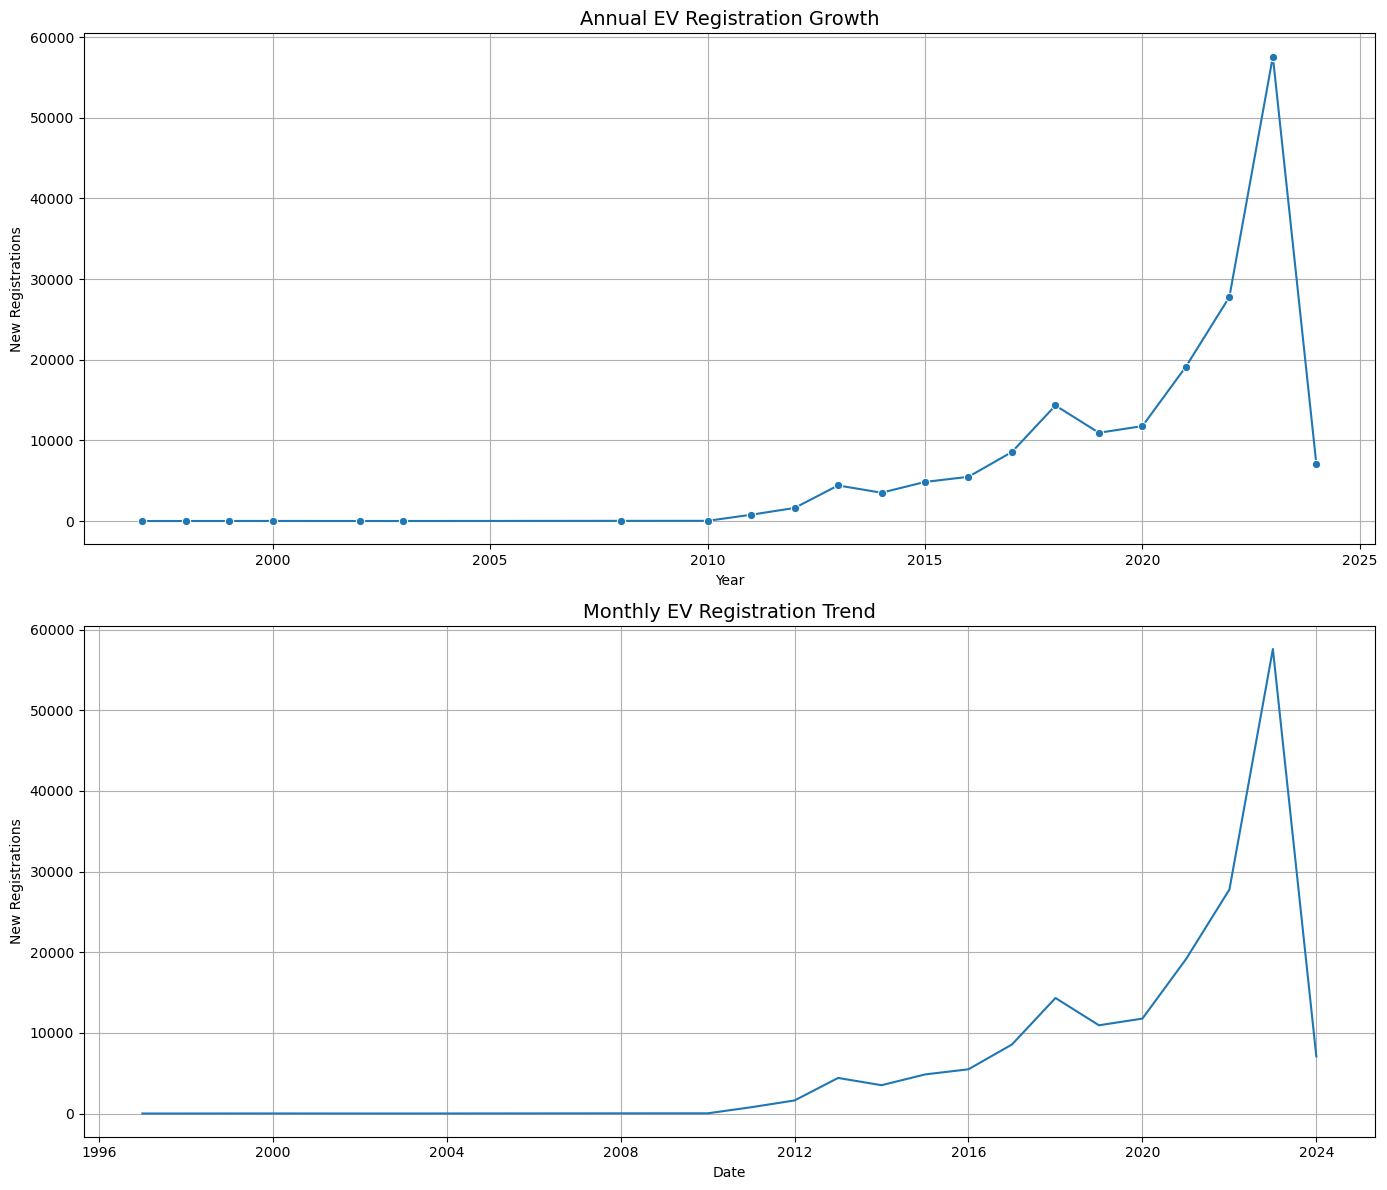

In [11]:
def analyze_growth(df):
    # Annual registrations
    annual_reg = df.groupby('Registration_Year').size().reset_index(name='Registrations')
    
    # Monthly registrations
    monthly_reg = df.groupby(['Registration_Year', 'Registration_Month']).size()
    monthly_reg = monthly_reg.reset_index(name='Registrations')
    monthly_reg['Date'] = pd.to_datetime(
        monthly_reg['Registration_Year'].astype(str) + '-' + 
        monthly_reg['Registration_Month'].astype(str))
    
    # Calculate growth metrics
    annual_reg['YoY_Growth'] = annual_reg['Registrations'].pct_change() * 100
    annual_reg['Cumulative'] = annual_reg['Registrations'].cumsum()
    
    # Plotting
    fig, ax = plt.subplots(2, 1, figsize=(14, 12))
    
    # Annual growth
    sns.lineplot(data=annual_reg, x='Registration_Year', y='Registrations', 
                 marker='o', ax=ax[0])
    ax[0].set_title('Annual EV Registration Growth', fontsize=14)
    ax[0].set_xlabel('Year')
    ax[0].set_ylabel('New Registrations')
    ax[0].grid(True)
    
    # Monthly trend
    sns.lineplot(data=monthly_reg, x='Date', y='Registrations', ax=ax[1])
    ax[1].set_title('Monthly EV Registration Trend', fontsize=14)
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('New Registrations')
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('growth_analysis.png', dpi=300)
    plt.show()
    
    return annual_reg, monthly_reg

annual_reg, monthly_reg = analyze_growth(df)


#### 2. Forecast Future Registrations

/home/issa/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/issa/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/issa/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/issa/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/issa/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: 

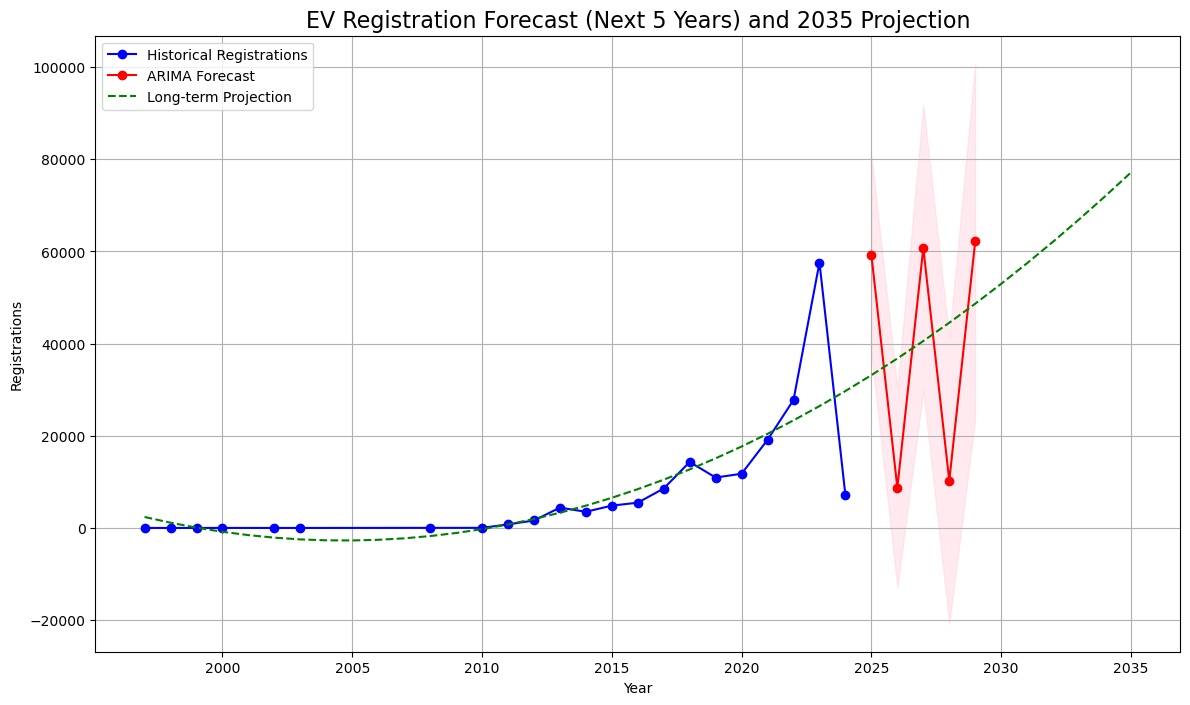

In [12]:
def forecast_registrations(annual_reg):
    # Prepare time series data
    ts_data = annual_reg.set_index('Registration_Year')['Registrations']
    
    # Fit ARIMA model
    model = ARIMA(ts_data, order=(2,1,1))
    model_fit = model.fit()
    
    # Forecast next 5 years
    forecast_years = list(range(ts_data.index.max() + 1, ts_data.index.max() + 6))
    forecast = model_fit.get_forecast(steps=5)
    forecast_df = forecast.conf_int()
    forecast_df['Forecast'] = forecast.predicted_mean
    forecast_df.index = forecast_years
    
    # Polynomial regression for long-term projection
    X = np.array(ts_data.index).reshape(-1, 1)
    y = ts_data.values
    
    poly = PolynomialFeatures(degree=2)
    X_poly = poly.fit_transform(X)
    
    lr_model = LinearRegression()
    lr_model.fit(X_poly, y)
    
    # Project until 2035
    future_years = np.array(range(X.min(), 2036)).reshape(-1,1)
    X_future = poly.transform(future_years)
    projections = lr_model.predict(X_future)
    
    # Create projection dataframe
    projection_df = pd.DataFrame({
        'Year': future_years.flatten(),
        'Projection': projections
    })
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    # Historical data
    plt.plot(ts_data.index, ts_data.values, 'bo-', label='Historical Registrations')
    
    # ARIMA forecast
    plt.plot(forecast_df.index, forecast_df['Forecast'], 'ro-', label='ARIMA Forecast')
    plt.fill_between(forecast_df.index, 
                     forecast_df['lower Registrations'], 
                     forecast_df['upper Registrations'],
                     color='pink', alpha=0.3)
    
    # Long-term projection
    plt.plot(projection_df['Year'], projection_df['Projection'], 'g--', 
             label='Long-term Projection')
    
    plt.title('EV Registration Forecast (Next 5 Years) and 2035 Projection', fontsize=16)
    plt.xlabel('Year')
    plt.ylabel('Registrations')
    plt.legend()
    plt.grid(True)
    plt.savefig('forecast.png', dpi=300)
    plt.show()
    
    return forecast_df, projection_df

forecast_df, projection_df = forecast_registrations(annual_reg)


#### 3. Distribution Analysis

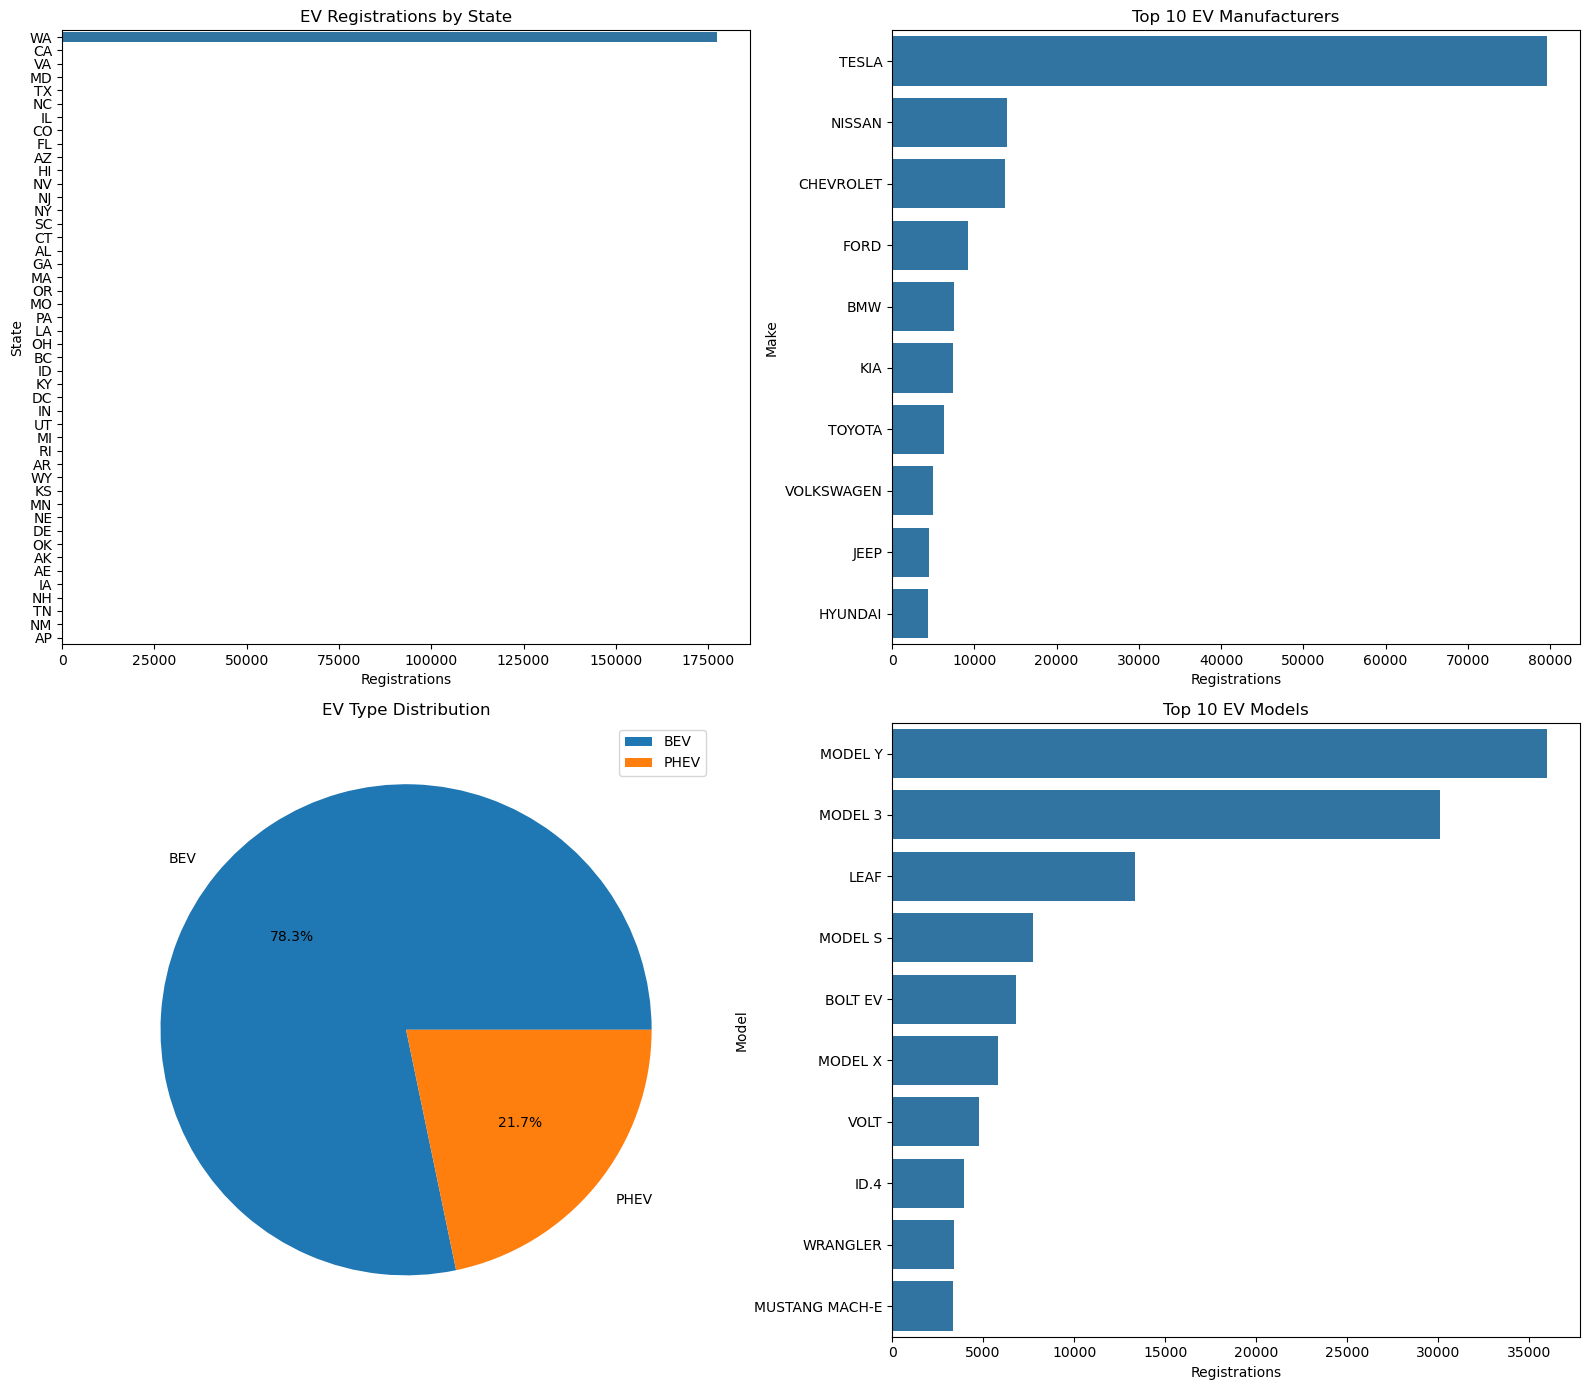

In [13]:
def analyze_distributions(df):
    # Regional distribution by state
    state_dist = df['State'].value_counts().reset_index()
    state_dist.columns = ['State', 'Registrations']
    
    # Brand analysis
    top_brands = df['Make'].value_counts().nlargest(10).reset_index()
    top_brands.columns = ['Make', 'Registrations']
    
    # EV type analysis
    ev_type_dist = df['EV_Type_Simple'].value_counts().reset_index()
    ev_type_dist.columns = ['EV_Type', 'Registrations']
    
    # Vehicle model analysis
    top_models = df['Model'].value_counts().nlargest(10).reset_index()
    top_models.columns = ['Model', 'Registrations']
    
    # Plotting
    fig, ax = plt.subplots(2, 2, figsize=(16, 14))
    
    # State distribution
    sns.barplot(data=state_dist, x='Registrations', y='State', ax=ax[0,0])
    ax[0,0].set_title('EV Registrations by State')
    
    # Top brands
    sns.barplot(data=top_brands, x='Registrations', y='Make', ax=ax[0,1])
    ax[0,1].set_title('Top 10 EV Manufacturers')
    
    # EV types
    ev_type_dist.plot(kind='pie', y='Registrations', autopct='%1.1f%%', 
                     labels=ev_type_dist['EV_Type'], ax=ax[1,0])
    ax[1,0].set_title('EV Type Distribution')
    ax[1,0].set_ylabel('')
    
    # Top models
    sns.barplot(data=top_models, x='Registrations', y='Model', ax=ax[1,1])
    ax[1,1].set_title('Top 10 EV Models')
    
    plt.tight_layout()
    plt.savefig('distributions.png', dpi=300)
    plt.show()
    
    # Geographic analysis (using Plotly for interactivity)
    geo_df = df.groupby(['County', 'State']).size().reset_index(name='Registrations')
    fig = px.choropleth(geo_df, 
                        locations='State', 
                        locationmode="USA-states",
                        color='Registrations',
                        scope="usa",
                        hover_name='County',
                        color_continuous_scale=px.colors.sequential.Plasma,
                        title='EV Registrations by County')
    fig.write_html('geographic_distribution.html')
    
    return state_dist, top_brands, ev_type_dist, top_models

state_dist, top_brands, ev_type_dist, top_models = analyze_distributions(df)

#### 4. Market Size and Growth Potential

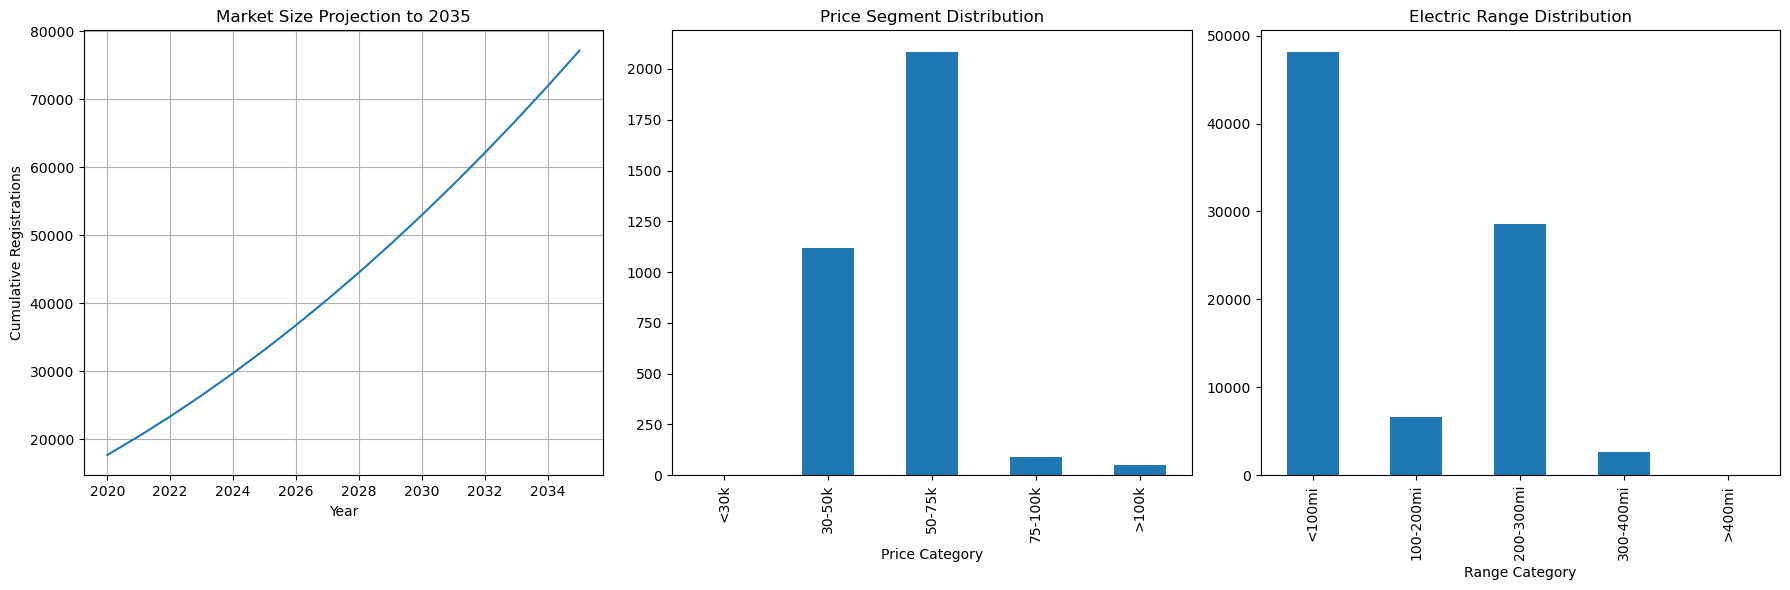

In [14]:
def analyze_market_potential(df, projection_df):
    # Current market size
    current_market_size = df.shape[0]
    
    # Market growth rate (last 3 years CAGR)
    recent_years = annual_reg[annual_reg['Registration_Year'] >= annual_reg['Registration_Year'].max() - 3]
    cagr = (recent_years['Registrations'].iloc[-1] / recent_years['Registrations'].iloc[0]) ** (1/3) - 1
    
    # Market segmentation by price
    price_bins = [0, 30000, 50000, 75000, 100000, float('inf')]
    price_labels = ['<30k', '30-50k', '50-75k', '75-100k', '>100k']
    df['Price_Category'] = pd.cut(df['Base MSRP'], bins=price_bins, labels=price_labels)
    price_dist = df['Price_Category'].value_counts().sort_index()
    
    # Electric range analysis
    range_bins = [0, 100, 200, 300, 400, float('inf')]
    range_labels = ['<100mi', '100-200mi', '200-300mi', '300-400mi', '>400mi']
    df['Range_Category'] = pd.cut(df['Electric Range'], bins=range_bins, labels=range_labels)
    range_dist = df['Range_Category'].value_counts().sort_index()
    
    # Plotting
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Market growth potential
    projection_df[projection_df['Year'] >= 2020].plot(
        x='Year', y='Projection', ax=ax[0], legend=False)
    ax[0].set_title('Market Size Projection to 2035')
    ax[0].set_ylabel('Cumulative Registrations')
    ax[0].grid(True)
    
    # Price distribution
    price_dist.plot(kind='bar', ax=ax[1])
    ax[1].set_title('Price Segment Distribution')
    ax[1].set_xlabel('Price Category')
    
    # Range distribution
    range_dist.plot(kind='bar', ax=ax[2])
    ax[2].set_title('Electric Range Distribution')
    ax[2].set_xlabel('Range Category')
    
    plt.tight_layout()
    plt.savefig('market_potential.png', dpi=300)
    plt.show()
    
    return {
        'current_market_size': current_market_size,
        'cagr': cagr,
        'price_distribution': price_dist,
        'range_distribution': range_dist
    }

market_metrics = analyze_market_potential(df, projection_df)

#### 5. Generate Stakeholder Insights

In [15]:
def generate_insights(annual_reg, forecast_df, state_dist, top_brands, market_metrics):
    # Calculate key metrics
    growth_last_year = annual_reg['YoY_Growth'].iloc[-1]
    forecast_growth = (forecast_df['Forecast'].iloc[-1] - annual_reg['Registrations'].iloc[-1]) / annual_reg['Registrations'].iloc[-1]
    
    # Prepare insights report
    insights = f"""
    Electric Vehicle Market Analysis Report
    {'='*50}
    
    1. Market Growth Summary:
    - Current market size: {market_metrics['current_market_size']:,} EVs
    - Last year growth rate: {growth_last_year:.1f}%
    - 3-year CAGR: {market_metrics['cagr']:.1%}
    - Projected growth next 5 years: {forecast_growth:.1%}
    
    2. Regional Hotspots:
    - Top state: {state_dist.iloc[0]['State']} ({state_dist.iloc[0]['Registrations']:,} EVs)
    - Second largest market: {state_dist.iloc[1]['State']} ({state_dist.iloc[1]['Registrations']:,} EVs)
    
    3. Competitive Landscape:
    - Market leader: {top_brands.iloc[0]['Make']} ({top_brands.iloc[0]['Registrations']:,} EVs)
    - Second position: {top_brands.iloc[1]['Make']} ({top_brands.iloc[1]['Registrations']:,} EVs)
    - Combined market share of top 3 brands: {
        top_brands['Registrations'].iloc[:3].sum()/top_brands['Registrations'].sum():.1%}
    
    4. Market Segmentation:
    - Dominant price segment: {market_metrics['price_distribution'].index[0]} 
      ({market_metrics['price_distribution'].iloc[0]/sum(market_metrics['price_distribution']):.1%})
    - Most common range category: {market_metrics['range_distribution'].index[0]} 
      ({market_metrics['range_distribution'].iloc[0]/sum(market_metrics['range_distribution']):.1%})
    
    5. Strategic Recommendations:
    - Infrastructure Planning: Focus charging station deployment in {state_dist.iloc[0]['State']} and {state_dist.iloc[1]['State']}
    - Product Development: Prioritize {market_metrics['price_distribution'].index[0]} price segment with {market_metrics['range_distribution'].index[0]} range
    - Policy Focus: Implement incentives in underpenetrated states to stimulate growth
    - Production Strategy: Increase manufacturing capacity to meet projected {forecast_df['Forecast'].iloc[-1]:.0f} annual registrations in {forecast_df.index[-1]}
    """
    
    print(insights)
    
    # Save insights to file
    with open('ev_market_insights.txt', 'w') as f:
        f.write(insights)
        
    return insights

insights = generate_insights(annual_reg, forecast_df, state_dist, top_brands, market_metrics)


    Electric Vehicle Market Analysis Report
    
    1. Market Growth Summary:
    - Current market size: 177,866 EVs
    - Last year growth rate: -87.7%
    - 3-year CAGR: -28.2%
    - Projected growth next 5 years: 778.3%
    
    2. Regional Hotspots:
    - Top state: WA (177,477 EVs)
    - Second largest market: CA (101 EVs)
    
    3. Competitive Landscape:
    - Market leader: TESLA (79,659 EVs)
    - Second position: NISSAN (13,998 EVs)
    - Combined market share of top 3 brands: 70.7%
    
    4. Market Segmentation:
    - Dominant price segment: <30k 
      (0.0%)
    - Most common range category: <100mi 
      (56.1%)
    
    5. Strategic Recommendations:
    - Infrastructure Planning: Focus charging station deployment in WA and CA
    - Product Development: Prioritize <30k price segment with <100mi range
    - Policy Focus: Implement incentives in underpenetrated states to stimulate growth
    - Production Strategy: Increase manufacturing capacity to meet projected 62183